In [2]:
import numpy as np
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import ReLU
from keras.layers import Activation
from keras.layers import BatchNormalization
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
# import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
def give_image(path, batch_size):
    
    img_arr = []
    
    files = listdir(path)
    files_len = len(files)
#     print(files_len)
    for k in range(batch_size):
#         print(k)
        file_num = np.random.randint(0, files_len)
#         print(file_num)
        img_name = files[file_num]
#         print(img_name)
        path2 = path + img_name
#         print(path2)
        img = load_img(path2)
        img = img_to_array(img)
        img = img[:,:,0]/255.0
        img_arr.append(img)
        path2 = path
    
    img_arr = np.array(img_arr)
    return img_arr

In [3]:
def select_img(batch_size):
    
    rint = np.random.randint(1, 5)
    
    base_path = 'munich/labelled/'
    
    # barren land
    if(rint==1):
        barren = base_path + 'barren land/pure_barren/s1/'
        img = give_image(barren, batch_size)
        label = np.array([[1,0,0,0]]*batch_size)
        class_type = 'barren'
#         plt.imshow(img, cmap='Greys')
    
    # grassland
    if(rint==2):
        grass = base_path + 'grass/grass_dirt/s1/'
        img = give_image(grass, batch_size)
        label = np.array([[0,1,0,0]]*batch_size)
        class_type = 'grassland'
    #     plt.imshow(img, cmap='Greys')
    
    # grid
    if(rint==3):
        grid = base_path + 'grid/s1/'
        img = give_image(grid, batch_size)
        label = np.array([[0,0,1,0]]*batch_size)
        class_type = 'agri_grid'
    #     plt.imshow(img, cmap='Greys')
    
    # urban
    if(rint==4):
        urban = base_path + 'urban/s1/'
        img = give_image(urban, batch_size)
        label = np.array([[0,0,0,1]]*batch_size)
        class_type = 'urban'
    #     plt.imshow(img, cmap='Greys')
    
    return img, label, class_type

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
(3, 4)
agri_grid


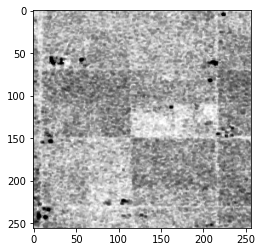

In [4]:
img, label, class_type = select_img(3)
print(label)
print(label.shape)
print(class_type)
plt.imshow(img[0], cmap='Greys')

In [5]:
from keras.layers import Flatten
from keras.layers import Dense
def define_classifier(image_shape):
    
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    
    x = Conv2D(32, (4,4), strides=(4,4), padding='same', kernel_initializer=init)(in_image)
    x = ReLU()(x)
    
    x = Conv2D(64, (4,4), strides=(4,4), padding='same', kernel_initializer=init)(x)
#     x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
#     x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
#     x = BatchNormalization()(x)
    x = ReLU()(x)
    
#     x = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
# #     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
#     x = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
# #     x = BatchNormalization()(x)
#     x = ReLU()(x)
    
    x = Flatten()(x)
    x = Dense(128, activation = 'relu', kernel_initializer=init)(x)
    out = Dense(4, activation = 'softmax', kernel_initializer=init)(x)
    
    model = Model(in_image, out)
    
    model.compile(loss='categorical_crossentropy', optimizer='sgd')
    
    return model

In [6]:
classi = define_classifier((256,256,1))
classi.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        544       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         131200    
_________________________________________________________________
re_lu_3 (ReLU)               (None, 8, 8, 128)         0   

In [7]:
def summarize_performance(step, c_model):
    
    img, label, class_type = select_img(1)
    img_arr = img.reshape((1, 256 ,256 , 1))
    x = c_model.predict(img_arr)
    x = np.around(x, decimals=3)
    
    s = class_type + ' ' + str(x)
    plt.axis('off')
    plt.text(0, 280, s, fontsize=10)
    plt.imshow(img[0], cmap='gray')
    
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    
    filename2 = 'c_model_%06d.h5' % (step+1)
    c_model.save(filename2)
    
    print('>Saved: %s and %s' % (filename1, filename2))

In [8]:
def train(c_model, n_images, n_epochs=15, n_batch=3):
    
    bat_per_epo = int(n_images / n_batch)
    n_steps = bat_per_epo * n_epochs
    
    for i in range(n_steps):
        
        img_arr, label, _ = select_img(n_batch)
        img_arr = img_arr.reshape((n_batch, 256 ,256 , 1))
        
        c_loss = c_model.train_on_batch(img_arr, label)
        
		# summarize performance
        if (i+1) % 1436 == 0:
            print('>%d, c_loss[%.3f]' % (i+1, c_loss))
		# summarize model performance
        if (i+1) % 2154 == 0:
            summarize_performance(i, c_model)

In [9]:
image_shape = (256,256,1)

n_images = 8621

c_model = define_classifier(image_shape)

train(c_model, n_images)

>1436, c_loss[1.455]
>Saved: plot_002154.png and c_model_002154.h5
>2872, c_loss[1.444]
>4308, c_loss[1.296]
>Saved: plot_004308.png and c_model_004308.h5
>5744, c_loss[1.484]
>Saved: plot_006462.png and c_model_006462.h5
>7180, c_loss[1.390]
>8616, c_loss[1.454]
>Saved: plot_008616.png and c_model_008616.h5
>10052, c_loss[1.422]
>Saved: plot_010770.png and c_model_010770.h5
>11488, c_loss[1.118]
>12924, c_loss[1.267]
>Saved: plot_012924.png and c_model_012924.h5
>14360, c_loss[1.341]
>Saved: plot_015078.png and c_model_015078.h5
>15796, c_loss[1.573]
>17232, c_loss[1.636]
>Saved: plot_017232.png and c_model_017232.h5
>18668, c_loss[1.188]
>Saved: plot_019386.png and c_model_019386.h5
>20104, c_loss[0.913]
>21540, c_loss[1.347]
>Saved: plot_021540.png and c_model_021540.h5
>22976, c_loss[0.743]
>Saved: plot_023694.png and c_model_023694.h5
>24412, c_loss[0.997]
>25848, c_loss[0.488]
>Saved: plot_025848.png and c_model_025848.h5
>27284, c_loss[0.393]
>Saved: plot_028002.png and c_model_

____________________
**TEST AREA**

[[0. 1. 0. 0.]]


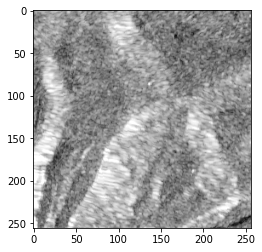

In [23]:
pic = load_img('munich\labelled\\barren land\\barren_urban\s1\ROIs1970_fall_s1_16_p402.png')
pic = img_to_array(pic)
pic = pic[:,:,0]/255.0
plt.imshow(pic,cmap='gray')
pic_arr = pic.reshape((1,256,256,1))

x = c_model.predict(pic_arr)
x = np.around(x, decimals=3)
print(x)

In [11]:
# img, label, class_type = select_img(1)
# x = c_model.predict

# a = np.array([1.2345,1.2345,1.2345,1.2345])
# x = np.around(a,decimals=2)
# print(x)

In [12]:
# x = np.array([1, 2, 3, 4])
# print(x.shape)
# print(x)
# x = np.reshape(x, (1,4))
# print(x.shape)
# print(x)